In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"zpnick","key":"1e248d72909a2dd35723f677a43e15e5"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d 'tanlikesmath/diabetic-retinopathy-resized'
#unzip
!mkdir diabetic-retinopathy-resized
!unzip diabetic-retinopathy-resized.zip -d diabetic-retinopathy-resized
#!mv ./* diabetic-retinopathy-resized
! rm /content/diabetic-retinopathy-resized/diabetic-retinopathy-resized.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflating: diabetic-retinopathy

In [2]:
! rm /content/diabetic-retinopathy-resized.zip

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Libraries
import json
import math
import os


import scipy as sp
from functools import partial
from collections import Counter
import json

import cv2
from PIL import Image
import numpy as np
from keras import backend as K
from keras import layers
import tensorflow as tf
#from keras_efficientnets import *
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
warnings.filterwarnings("ignore")
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping
%matplotlib inline

In [4]:
# Image size
im_size = 224
# Batch size
BATCH_SIZE = 32

# Loading & Merging

In [5]:
#new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('/content/diabetic-retinopathy-resized/trainLabels_cropped.csv')
#print(new_train.shape)
print(old_train.shape)

(35108, 4)


In [6]:
old_train = old_train[['image','level']]

old_train['filenames'] = [i+".jpeg" for i in old_train['image'].values]

train_df = old_train.copy()


In [7]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train,val=train_test_split(train_df,test_size=0.3,stratify=train_df.level)
val,test=train_test_split(val,test_size=0.3,stratify=val.level)

print(train.shape)
print(val.shape)
print(test.shape)

(24575, 3)
(7373, 3)
(3160, 3)


In [ ]:
pd.value_counts(test.level)

0    2336
2     452
1     231
3      83
4      58
Name: level, dtype: int64

# Process Images



(29841,) (29841,) (5267,) (5267,)


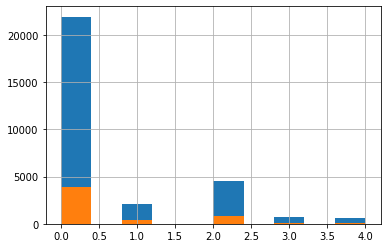

In [ ]:
df_train = pd.read_csv('/content/diabetic-retinopathy-resized/trainLabels_cropped.csv')
#df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['image']
y = df_train['level']

#x, y = shuffle(x, y, random_state=SEED)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=1)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

CPU times: user 1.01 s, sys: 146 ms, total: 1.16 s
Wall time: 1.22 s


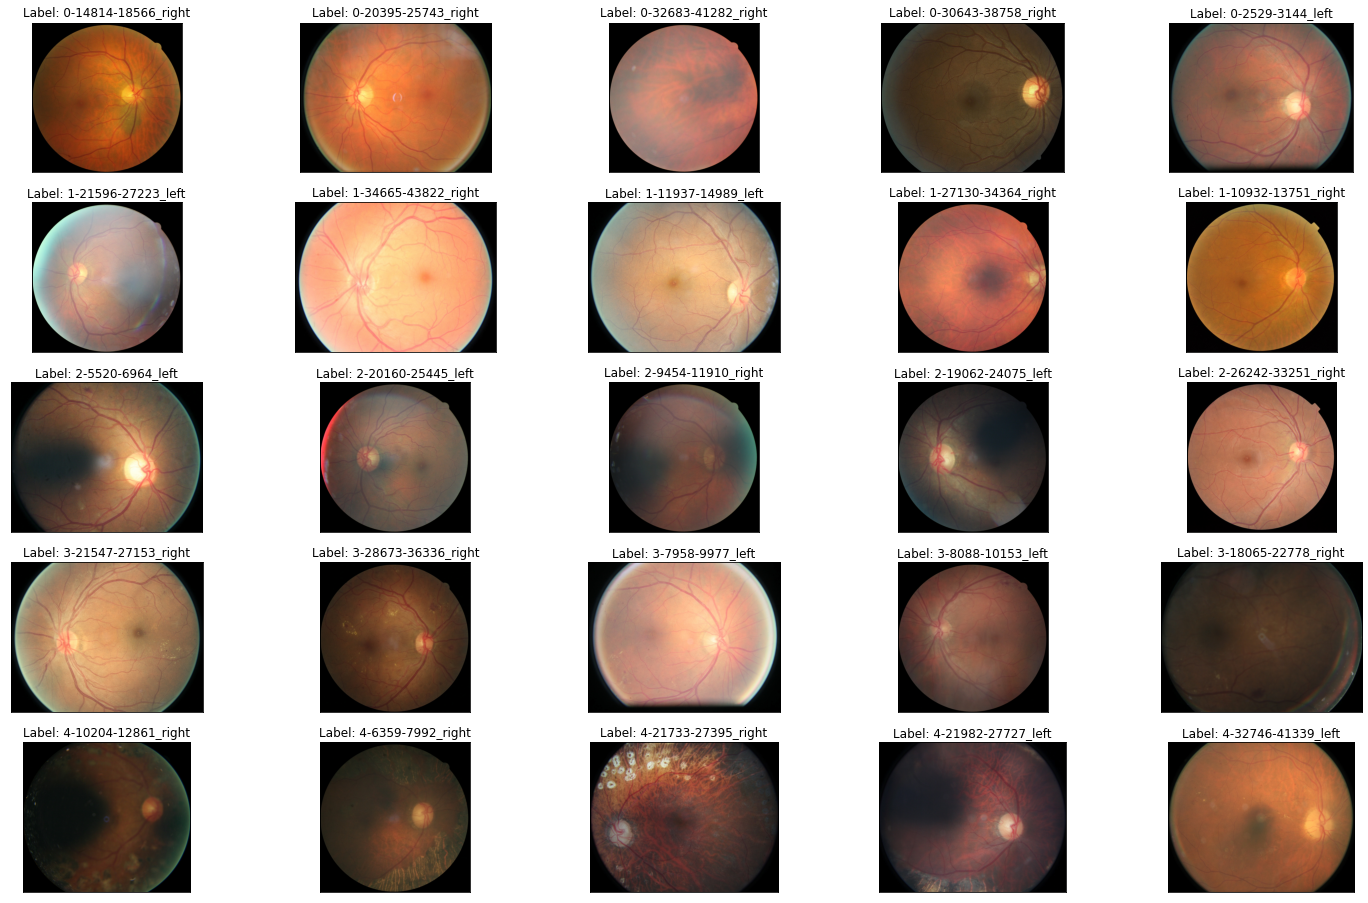

In [ ]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(5, random_state=1).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['image']) )

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (im_size, im_size))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image


CPU times: user 4.92 s, sys: 34.1 ms, total: 4.95 s
Wall time: 3.31 s


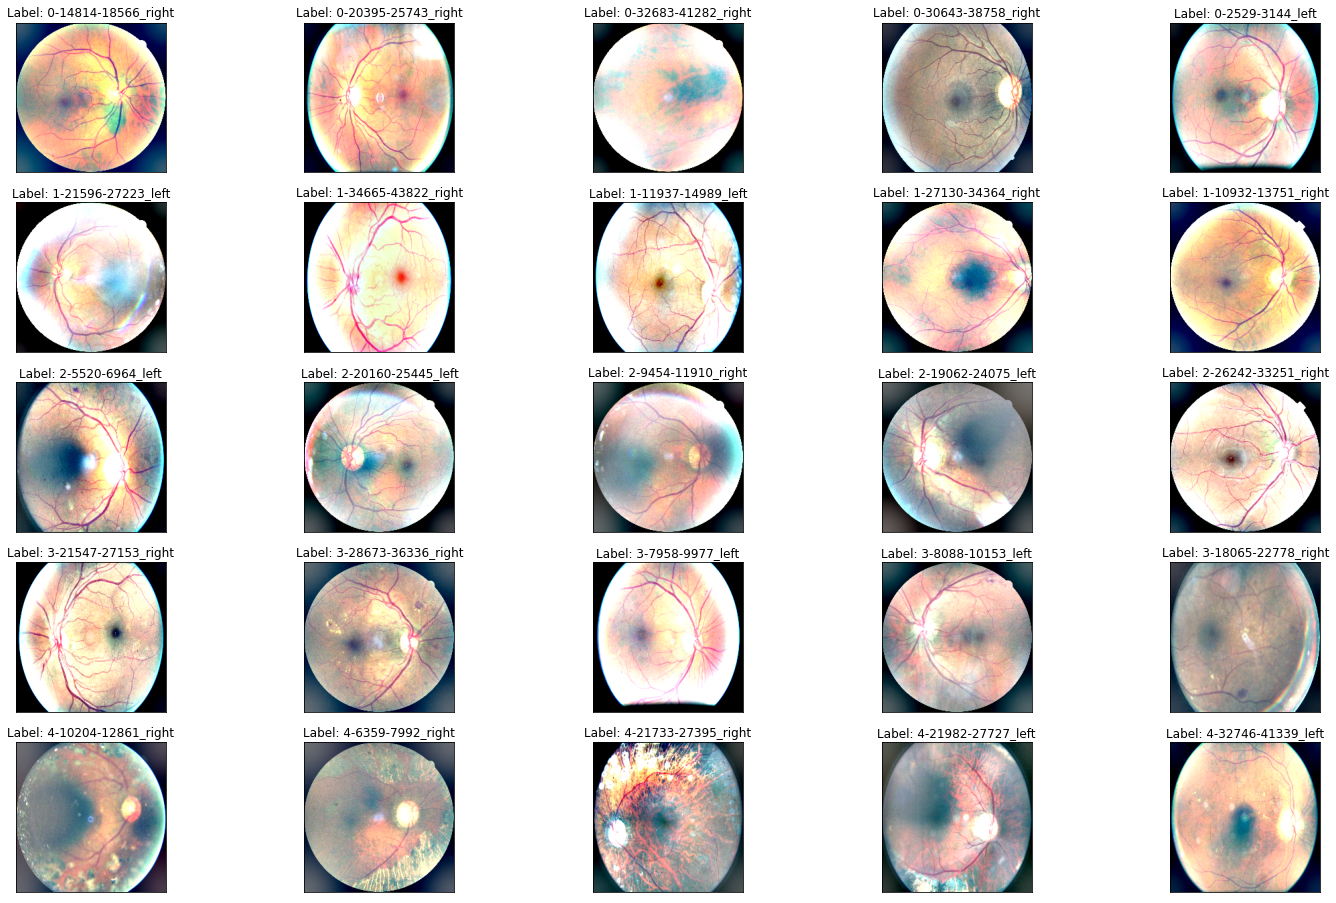

In [ ]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(5, random_state=1).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['image']) )

CPU times: user 1.75 s, sys: 17.7 ms, total: 1.77 s
Wall time: 1.5 s


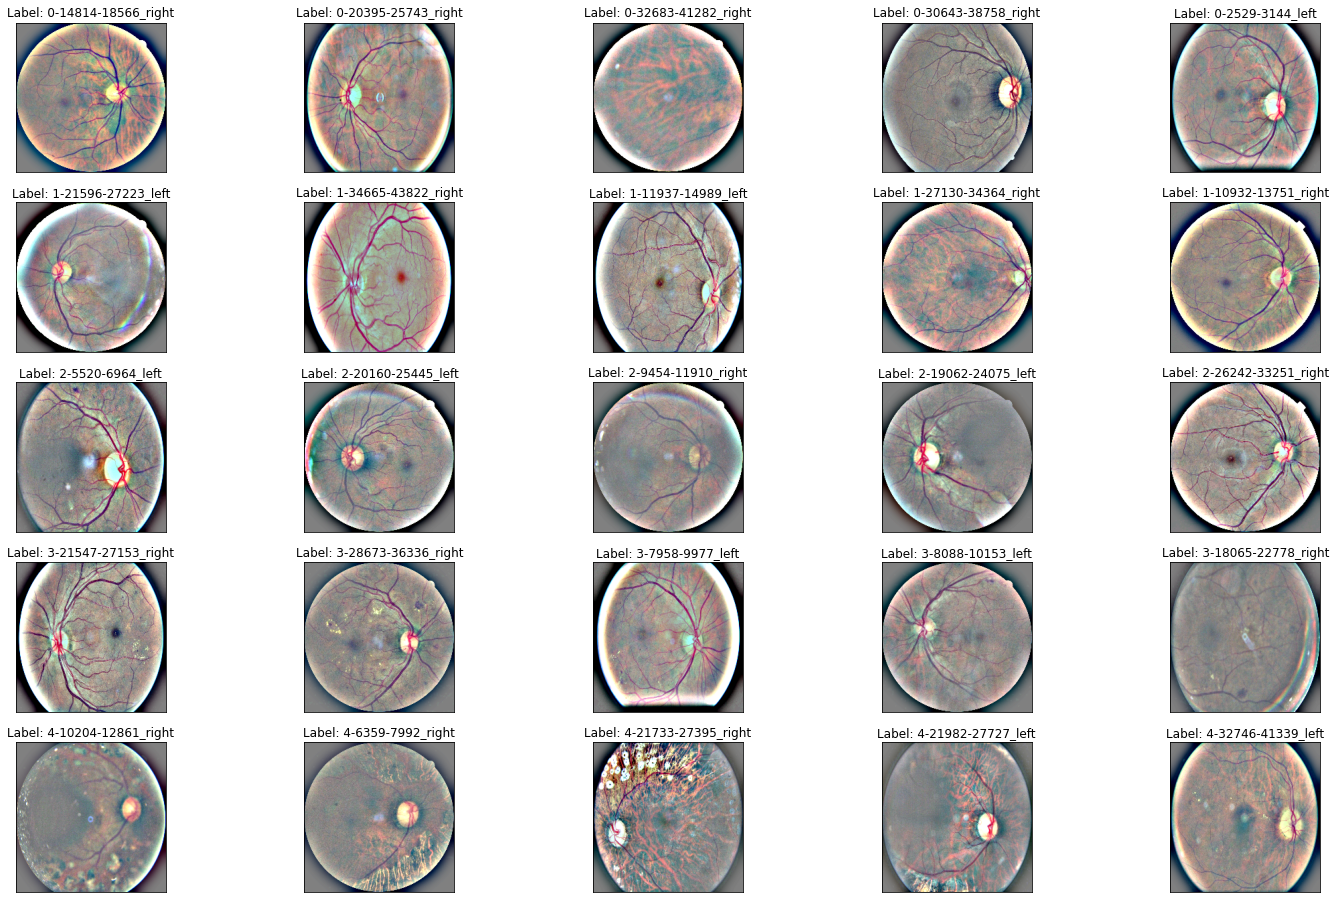

In [ ]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(5, random_state=1).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = load_ben_color(path,sigmaX=10)

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['image']) )

In [ ]:
def circle_crop(img, desired_size,sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

CPU times: user 6.54 s, sys: 63.9 ms, total: 6.61 s
Wall time: 4.46 s


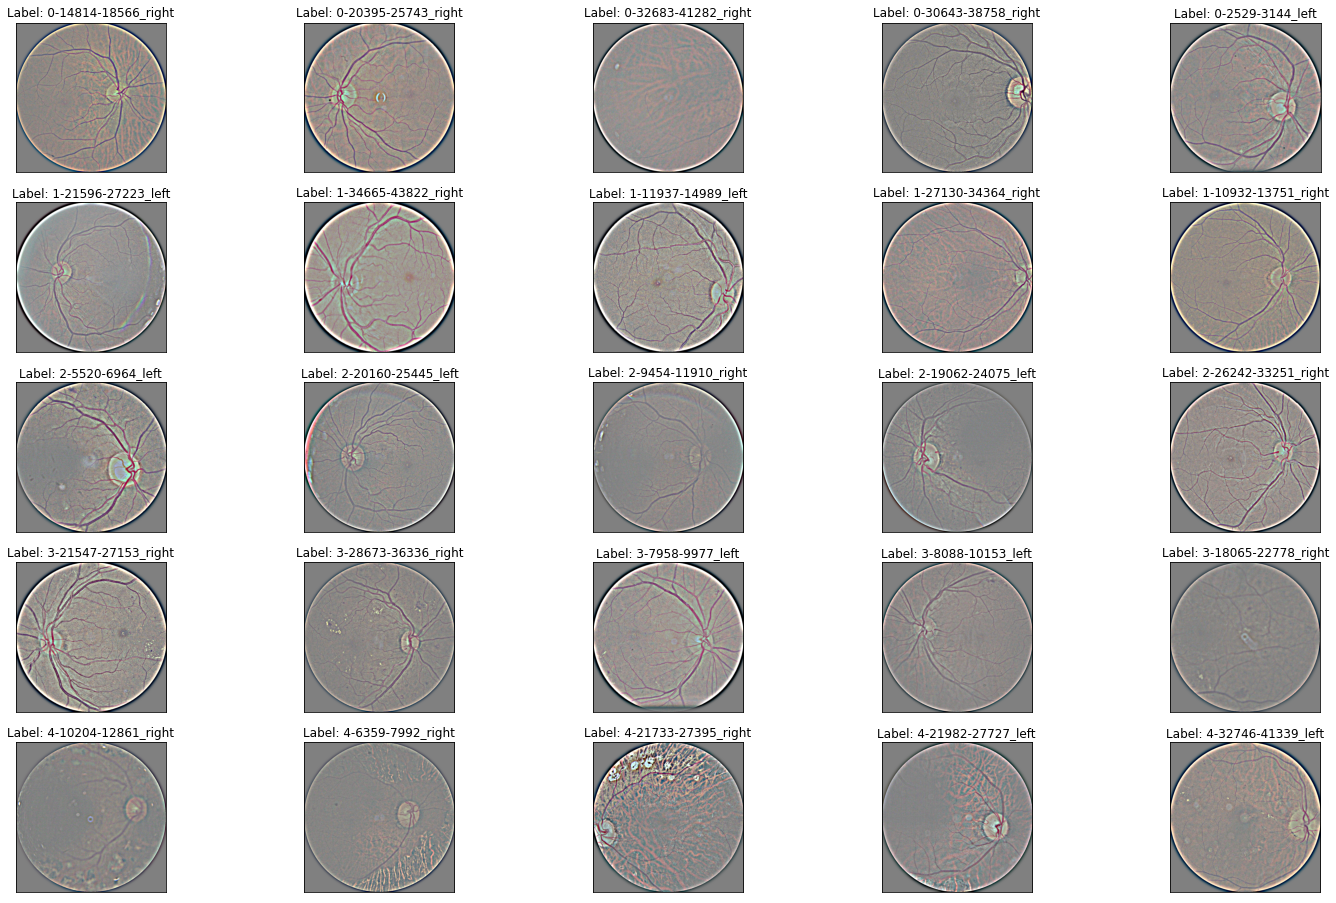

In [ ]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['level'] == class_id].sample(5, random_state=1).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/content/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/{row['image']}.jpeg"
        image = circle_crop(path,sigmaX=10)

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['image']) )

In [8]:
datagen = ImageDataGenerator(        
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 160,
        zoom_range=0.35)


train_gen = datagen.flow_from_dataframe(
                                            dataframe = train, directory='/content/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=(im_size,im_size), color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True, 
                                        )

val_gen = datagen.flow_from_dataframe(
                                            dataframe = val, directory='/content/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=(im_size,im_size), color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True, 
                                        )

test_gen = datagen.flow_from_dataframe(
                                            dataframe = test, directory='/content/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=(im_size,im_size), color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True, 
                                        )


Found 24575 validated image filenames.
Found 7373 validated image filenames.
Found 3160 validated image filenames.


In [9]:
from tensorflow.keras.utils import to_categorical

y_test = test.level.map(lambda x: to_categorical(x, 5))
y_test = np.asarray(list(y_test))
y_test

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

# Model: EfficientNetB3

In [10]:
im_size=224
effnet = tf.keras.applications.EfficientNetB3(
    input_shape=(im_size,im_size,3),
    weights='imagenet',
    include_top=False
)

43950080/43941136 [==============================] - 1s 0us/step


In [ ]:
effnet.summary()

In [12]:
def build_model(n_labels):
    model=effnet
    model.trainable=False
    
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(n_labels, activation="softmax", name="pred")(x)
    # Compile
    model = tf.keras.Model(model.input, outputs, name="EfficientNet")
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    '''
    model=effnet
    model.trainable=False
    
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="linear", name="pred")(x)
    # Compile
    model = tf.keras.Model(model.input, outputs, name="EfficientNet")
    
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(lr=0.0001,decay=1e-5),
        metrics=['mae']
    )
    '''
    return model

In [ ]:
model = build_model(5)
model.summary()

# Training & Evaluation

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from prettytable import PrettyTable
# Test model using test dataset
def test(model, y_test, test_gen):
    
    x_test = test_gen
    y_pred = model.predict(x_test, batch_size=100)
    print("Groud Truth values: ",y_test.shape)
    print(y_test)
    print('-'*40)
    print("Predicted values: ",y_pred.shape)
    print(y_pred)
    pred = np.argmax(y_pred, axis=1)
    test = np.argmax(y_test, axis=1)
    #pred = y_pred.round()
    #test = y_test.round()
    accuracy = (np.sum(np.argmax(y_pred, 1) == np.argmax(y_test,1))/y_test.shape[0])
    precision = metrics.precision_score(test, pred,average='weighted')
    recall = metrics.recall_score(test, pred,average='weighted')

    f1 = metrics.f1_score(test, pred,average='weighted')
    print(" ")
    Cnn_Table = PrettyTable(['EfficientNet Performance Metrics', '%'])
  
    # Add rows
    Cnn_Table.add_row(['Accuracy ',accuracy])
    Cnn_Table.add_row(['Precision',precision])
    Cnn_Table.add_row(['Recall/Sensitivity   ',recall])
    Cnn_Table.add_row(['F1_score ',f1])
    #myTable.add_row(['MLP_Confusion_Matrix',matrix])

    print(Cnn_Table)

    #Confusion Matrix
    print(" ")
    matrix = metrics.confusion_matrix(test, pred)
    print(" ")
    print('EfficientNet_Confusion_Matrix:')
    print(" ")
    print(matrix)
    print(" ")
    
    print("classification_report: ")
    print('-'*40)
    print(metrics.classification_report(test, pred))
    
    
   
    
    # Plotting ROC curve
    y = y_test
    # Binarize the output
    y = label_binarize(y, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC for specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to specific class')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' ')
    
    # Plot ROC curve for multi class
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
print("Model is ready to Test")

Model is ready to Test


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0)

In [ ]:
#kappa_metrics = Metrics(val_gen)
#kappa_metrics.val_kappas = []
steps_per_epoch = train_gen.n // BATCH_SIZE
validation_steps = val_gen.n //BATCH_SIZE
epochs = 10

history = model.fit_generator(train_gen, steps_per_epoch = steps_per_epoch,
                    validation_data=val_gen, validation_steps=validation_steps,
                    epochs=10)

Groud Truth values:  (3160, 5)
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
----------------------------------------
Predicted values:  (3160, 5)
[[9.03576076e-01 2.22469755e-02 5.92252649e-02 1.39459493e-02
  1.00571604e-03]
 [7.41741538e-01 1.09227195e-01 1.43107131e-01 2.94866599e-03
  2.97550228e-03]
 [8.15281928e-01 5.10329567e-03 1.72311068e-01 9.15994518e-04
  6.38762349e-03]
 ...
 [7.76331067e-01 6.24227114e-02 1.49307996e-01 8.01735185e-03
  3.92090855e-03]
 [9.09214914e-01 3.67653929e-02 5.25144525e-02 8.31611338e-04
  6.73582370e-04]
 [8.60021353e-01 3.50951739e-02 8.41852948e-02 5.57394791e-03
  1.51242185e-02]]
 
+----------------------------------+--------------------+
| EfficientNet Performance Metrics |         %          |
+----------------------------------+--------------------+
|            Accuracy              | 0.7117088607594937 |
|            Precision             | 0.5679043993296039 |
|      

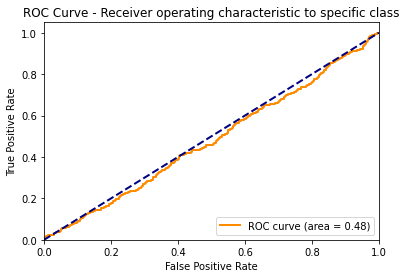

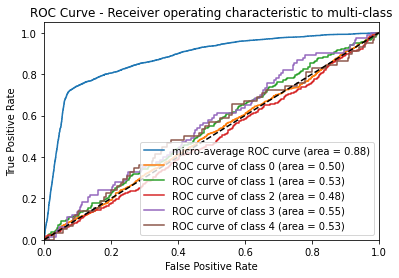

In [ ]:
test(model, y_test, test_gen)